<a href="https://colab.research.google.com/github/12058/MCA/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pillow
!pip install tqdm


In [ ]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, Embedding, Dropout
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing import image


tqdm().pandas()

0it [00:00, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile

# Path to your zip files in Google Drive
zip_path = '/content/drive/My Drive/Image_Captioning/'

# Unzip the Flickr8k_Dataset.zip
with zipfile.ZipFile(zip_path + 'Flickr8k_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Unzip the Flickr8k_text.zip
with zipfile.ZipFile(zip_path + 'Flickr8k_text.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [ ]:
# Load the document file into memory
import string

def load_doc(filename):
    # Open file to read
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Get all images with their captions
def img_capt(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}

    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)

    return descriptions

# Data cleaning function
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            descp = img_caption.split()
            # Uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            # Remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            # Remove hanging 's and a
            descp = [wrd for wrd in descp if (len(wrd) > 1)]
            # Remove words containing numbers
            descp = [wrd for wrd in descp if (wrd.isalpha())]
            # Converting back to string
            img_caption = ' '.join(descp)
            captions[img][i] = img_caption

    return captions

# To build a vocabulary of all unique words
def txt_vocab(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

# To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)

    data = "\n".join(lines)
    file = open(filename, "w")
    file.write(data)
    file.close()


In [ ]:
# Set these paths according to your Google Drive folder structure
dataset_text = "/content/drive/My Drive/Image_Captioning/Flickr8k_text"
dataset_images = "/content/drive/My Drive/Image_Captioning/Flickr8k_Dataset"


In [ ]:
# To prepare our text data
filename ="/content/Flickr8k.token.txt"

import os

if os.path.exists(filename):
    # File exists, proceed with loading it
    descriptions = img_capt(filename)
    print("Length of descriptions =", len(descriptions))
else:
    print(f"File not found at path: {filename}")

clean_descriptions = txt_clean(descriptions)


Length of descriptions = 8092


In [ ]:
# To build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

# Saving all descriptions in one file
save_descriptions(clean_descriptions, "/content/drive/My Drive/Image_Captioning/descriptions.txt")


Length of vocabulary = 8422


In [ ]:
def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}

    for pic in tqdm(os.listdir(directory)):
        file = os.path.join(directory, pic)
        img = image.load_img(file, target_size=(299, 299))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = model.predict(img)
        features[pic] = feature

    return features

In [ ]:
# Set the path to the directory containing your images
# Set the path to the directory containing your images
dataset_images = "/content/Flicker8k_Dataset"


In [ ]:
# Extract features for all images and save to a pickle file
features = extract_features(dataset_images)

# Save the features to a pickle file named "features.p"
with open("features.p", "wb") as pickle_file:
    dump(features, pickle_file)


83683744/83683744 [==============================] - 3s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 355ms/step


In [ ]:
# Define the load_photos function
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


In [ ]:
# Define the load_clean_descriptions function
def load_clean_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = {}

    for line in file.split("\n"):
        words = line.split()

        if len(words) < 1:
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []

            desc = ' ' + " ".join(image_caption) + ' '
            descriptions[image].append(desc)

    return descriptions


In [ ]:
# Define the load_features function
def load_features(photos):
    # Load all features from the pickle file
    all_features = load(open("features.p", "rb"))

    # Select only the needed features
    features = {k: all_features[k] for k in photos}

    return features


In [ ]:
# Set the filename for loading training data
filename = "/content/Flickr_8k.trainImages.txt"

# Load the list of training images
train_imgs = load_photos(filename)

# Load clean descriptions for the training images
train_descriptions = load_clean_descriptions("/content/drive/My Drive/Image_Captioning/descriptions.txt", train_imgs)

# Load features for the training images
train_features = load_features(train_imgs)


In [ ]:
# Define the dict_to_list function
def dict_to_list(descriptions):
    all_desc = []

    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]

    return all_desc


In [ ]:
# Import the necessary library
from keras.preprocessing.text import Tokenizer

# Define the create_tokenizer function
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)

    return tokenizer

In [ ]:
# Create the tokenizer
tokenizer = create_tokenizer(train_descriptions)

# Save the tokenizer to a pickle file
dump(tokenizer, open('tokenizer.p', 'wb'))


In [ ]:
# Calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size  # The size of our vocabulary is 7577 words.


7318

In [ ]:
# Calculate the maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(train_descriptions)
max_length  # The maximum length of descriptions is 32.


33

In [ ]:
# Define the data_generator function
def data_generator(descriptions, features, tokenizer, max_length):
    while True:
        for key, description_list in descriptions.items():
            # Retrieve photo features
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]


In [ ]:
# Define the create_sequences function
def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()

    # Move through each description for the image
    for desc in desc_list:
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]

        # Divide one sequence into various X, y pairs
        for i in range(1, len(seq)):
            # Divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]

            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

            # Encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            # Store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)

    return np.array(x_1), np.array(x_2), np.array(y)


In [ ]:
# Generate data for model training (example)
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape  # ((47, 2048), (47, 32), (47, 7577))


((37, 2048), (37, 33), (37, 7318))

In [ ]:
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.models import Model
from keras.utils import plot_model

In [ ]:
# Define the define_model function
def define_model(vocab_size, max_length):
    # Features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Summarize model
    print(model.summary())

    return model

In [ ]:
# Create the captioning model
model = define_model(vocab_size, max_length)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 33)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 33, 256)              1873408   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                              

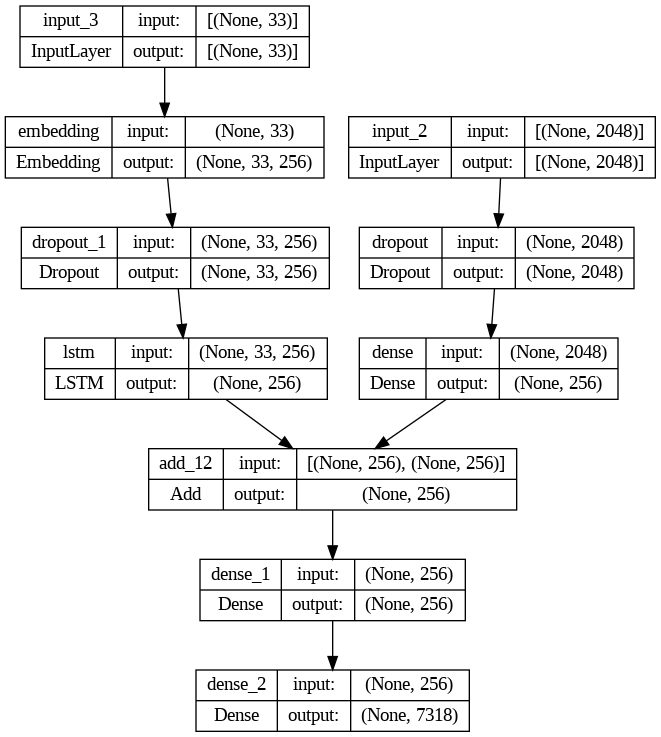

In [ ]:
# Plot and save the model architecture as an image
plot_model(model, to_file='model.png', show_shapes=True)


In [ ]:
# Print dataset information
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7318
Description Length:  33


In [ ]:
# Create and compile the model
model = define_model(vocab_size, max_length)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 33)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 33, 256)              1873408   ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_4[0][0]']             
                                                                                            

In [ ]:
# Define 'steps' based on the number of training descriptions
steps = len(train_descriptions)


In [38]:
epochs = 10

# Create a new directory to save models (use a different name)
os.mkdir("new_models")

# Loop through epochs and train the model
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    steps_per_epoch = len(train_descriptions)

    # Train the model for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)

    # Save the model
    model.save("new_models/model_epoch_" + str(i) + ".keras")


6000/6000 [==============================] - 1567s 261ms/step - loss: 2.9063


In [117]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set the image path to the location of your image in Google Colab
img_path = "/content/Flicker8k_Dataset/2056041678_d6b5b39b26.jpg"


In [118]:
# Function to extract image features using Xception model
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that the image path and extension are correct")
        return None

    image = image.resize((299, 299))
    image = np.array(image)

    # For 4-channel images, convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]

    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

# Function to map an integer to a word in the tokenizer
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to generate a description for an image
@tf.function
def generate_desc_in_tf(model, tokenizer, photo, sequence, max_length):
    pred = model([photo, sequence], training=False)
    pred = np.argmax(pred)
    return pred

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        pred = model.predict([photo, sequence], verbose=0)
        pred_word_index = np.argmax(pred)
        pred_word = word_for_id(pred_word_index, tokenizer)
        if pred_word is None or pred_word == 'end':
            break
        in_text += ' ' + pred_word
    return in_text




In [119]:
# Load the tokenizer (change the path to your tokenizer file)
tokenizer = load(open("/content/tokenizer.p", "rb"))

# Load the trained model (change the path to your model file)
model = load_model('/content/new_models/model_epoch_9.keras')

# Load the Xception model for feature extraction
xception_model = Xception(include_top=False, pooling="avg")


1/1 [==============================] - 1s 1s/step

Generated Description:
start of snow covered mountain mountains and mountains in the background and mountains and mountains in the background watch him stands on mountain range range in the background mountains in the background mountains behind


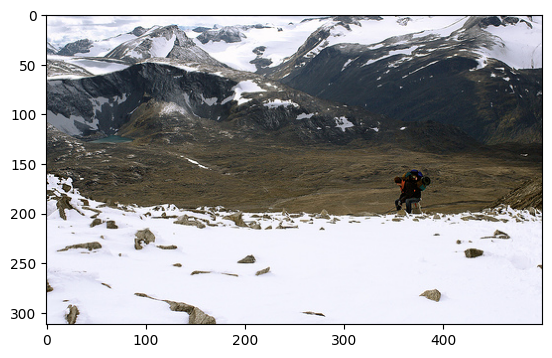

In [120]:
# Extract features from the provided image
photo = extract_features(img_path, xception_model)

# Open and display the image
img = Image.open(img_path)

# Calculate the maximum length of descriptions
max_length = 33  # Update the max_length to match the actual maximum length of descriptions

# ...

# Generate and print the description for the image
description = generate_desc(model, tokenizer, photo, max_length)
print("\nGenerated Description:")
print(description)


# Display the image
plt.imshow(img)
